In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [34]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json
import argparse
import logging 
import resource
import gc 
import secrets
from torch.utils.data import Subset


In [4]:
from ConceptBottleneck.CUB.dataset import load_data

In [5]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [6]:
torch.cuda.set_per_process_memory_fraction(0.5)
resource.setrlimit(resource.RLIMIT_AS, (30 * 1024 * 1024 * 1024, -1))
torch.set_num_threads(1)

In [7]:
logging.basicConfig(level=logging.INFO)
logging.info("Setting up dataset")

INFO:root:Setting up dataset


In [8]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    encoder_model='inceptionv3'
    seed = 44
    dataset_name = "CUB"
    train_variation = "none"
    model_type = "cem"
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")

    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--train_variation', type=str, default='none', help='Which train variation to analyze')
    parser.add_argument('--model_type', type=str, default='joint', help='Which train variation to analyze')

    args = parser.parse_args()
    encoder_model = "inceptionv3" 
    seed = args.seed 
    dataset_name = "CUB"
    train_variation = args.train_variation
    model_type = args.model_type

parameters = {
    'dataset': dataset_name,
    'seed': seed, 
    'encoder_model': encoder_model ,
    'debugging': False,
    'epochs': 100,
    'lr': 0.005,
    'train_variation': train_variation,
    'model_type': model_type,
}


In [9]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(1,encoder_model=encoder_model,dataset_name=dataset_name)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
parameters

{'dataset': 'CUB',
 'seed': 44,
 'encoder_model': 'inceptionv3',
 'debugging': False,
 'epochs': 100,
 'lr': 0.005,
 'train_variation': 'none',
 'model_type': 'cem'}

In [12]:
if model_type != 'joint':
    joint_model = get_synthetic_model(dataset_name,{'model_type': model_type, 'dataset': 'CUB', 'seed': seed})
else:
    joint_model = get_synthetic_model(dataset_name,parameters)
joint_model = joint_model.to(device)


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp9hz60njz
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp9hz60njz/_remote_module_non_scriptable.py


In [13]:
run_model_function = run_joint_model
if model_type == "cem":
    run_model_function = run_cem_model
elif model_type == "probcbm":
    run_model_function = run_probcbm_model

## Plot the Dataset

In [14]:
logging.info("Plotting Dataset")

INFO:root:Plotting Dataset


In [15]:
dataset_directory = "../../../../datasets"

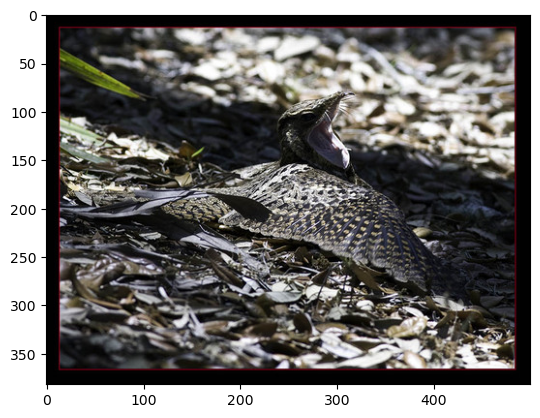

In [16]:
img_path = dataset_directory+'/'+train_pkl[0]['img_path']
image = Image.open(img_path)
plt.imshow(image)

## Accuracy

In [17]:
train_acc =  get_accuracy(joint_model,run_model_function,train_loader)
val_acc = get_accuracy(joint_model,run_model_function,val_loader)
test_acc = get_accuracy(joint_model,run_model_function,test_loader)

In [18]:
if model_type == 'joint':
    concept_acc = get_concept_accuracy_by_concept(joint_model,run_model_function,test_loader)
    locality_intervention = 1-torch.mean(concept_acc).detach().numpy()
    json.dump({'locality_intervention': locality_intervention},open("../../results/cub/locality_intervention.json","w"))

In [19]:
torch.cuda.empty_cache()

## Using Part Annotations

In [20]:
logging.info("Using part annotations")

INFO:root:Using part annotations


In [21]:
part_location = dataset_directory + "/CUB/metadata/parts/part_locs.txt"
part_list = dataset_directory + "/CUB/metadata/parts/parts.txt"

part_file = open(part_location).read().strip().split("\n")
part_list = open(part_list).read().strip().split("\n")
part_list = [' '.join(i.split(' ')[1:]) for i in part_list]

attribute_names = open(dataset_directory+"/CUB/metadata/attributes.txt").read().strip().split("\n")
attribute_names = [' '.join(i.split(' ')[1:]) for i in attribute_names]

In [22]:
parts_to_attribute = {}

for i in range(len(part_list)):
    if 'left' in part_list[i] or 'right' in part_list[i]:
        opposite = part_list[i].replace('left','RIGHT').replace('right','LEFT').lower()
        indices = sorted([i,part_list.index(opposite)])
        current_name = '^'.join([str(j) for j in indices])
    else:
        current_name = str(i)
    
    parts_to_attribute[current_name] = [] 
    parts_split = part_list[i].split(' ')

    for j in range(len(attribute_names)):
        main_part = set(attribute_names[j].split("::")[0].split("_"))

        if len(main_part.intersection(parts_split)) > 0:
            parts_to_attribute[current_name].append(j)

In [23]:
locations_by_image_id = {}
for i in part_file:
    split_vals = i.split(' ')

    if split_vals[-1] == '1':
        image_id = int(split_vals[0])
        part_id = int(split_vals[1])-1 # 0 index 
        x = float(split_vals[2])
        y = float(split_vals[3])

        if image_id not in locations_by_image_id:
            locations_by_image_id[image_id] = {}
        locations_by_image_id[image_id][part_id] = (x,y)

#### Impact of Masking on Predictions

In [24]:
logging.info("Impact of Epsilon")

INFO:root:Impact of Epsilon


In [25]:
with torch.no_grad():
    initial_predictions = [] 

    for data_point in test_loader:
        x,y,c = data_point 
        _, initial_predictions_batch = run_model_function(joint_model,x.to(device))
        initial_predictions_batch = torch.nn.Sigmoid()(initial_predictions_batch.detach().cpu().T)
        initial_predictions.append(initial_predictions_batch.numpy())
    initial_predictions = np.row_stack(initial_predictions)
    

In [26]:
torch.cuda.empty_cache()

In [27]:
valid_parts = [int(i) for i in parts_to_attribute if '^' not in i and parts_to_attribute[i] != []]

In [28]:
results_by_part_mask = {}

In [29]:
epsilon = 0.3
test_data_num = 100

In [30]:
main_part = valid_parts[0]
mask_part = valid_parts[0]
results_by_part_mask[part_list[main_part]] = {}

In [31]:
main_attributes = parts_to_attribute[str(main_part)]
mask_attributes = parts_to_attribute[str(mask_part)]
test_images, test_y, test_c = None, None, None 
gc.collect() 
test_images, test_y, test_c = unroll_data(test_loader)

valid_data_points = [i for i in range(len(test_pkl)) if main_part in locations_by_image_id[test_pkl[i]['id']] and mask_part in locations_by_image_id[test_pkl[i]['id']]]
data_points = random.sample(valid_data_points,test_data_num)
other_part_locations = [[get_part_location(data_point,new_part, locations_by_image_id, test_pkl) for new_part in valid_parts if new_part!=mask_part and new_part in locations_by_image_id[
    test_pkl[data_point]['id']]] for data_point in data_points]


In [32]:
gc.collect()

21

In [33]:
data_points = [1,2,3]

In [35]:
subset_loader = torch.utils.data.DataLoader(
    Subset(test_loader.dataset, data_points),
    batch_size=len(data_points),  # Load all at once for efficiency
    shuffle=False,
    num_workers=test_loader.num_workers,
    pin_memory=test_loader.pin_memory
)


In [38]:
for main_part in valid_parts:
    results_by_part_mask[part_list[main_part]] = {}
    for mask_part in valid_parts:
        main_attributes = parts_to_attribute[str(main_part)]
        mask_attributes = parts_to_attribute[str(mask_part)]
        test_images, test_y, test_c = None, None, None 
        gc.collect() 
        valid_data_points = [i for i in range(len(test_pkl)) if main_part in locations_by_image_id[test_pkl[i]['id']] and mask_part in locations_by_image_id[test_pkl[i]['id']]]
        data_points = random.sample(valid_data_points,test_data_num)
        other_part_locations = [[get_part_location(data_point,new_part, locations_by_image_id, test_pkl) for new_part in valid_parts if new_part!=mask_part and new_part in locations_by_image_id[
            test_pkl[data_point]['id']]] for data_point in data_points]
        subset_loader = torch.utils.data.DataLoader(
            Subset(test_loader.dataset, data_points),
            batch_size=len(data_points),  # Load all at once for efficiency
            shuffle=False,
            num_workers=test_loader.num_workers,
            pin_memory=test_loader.pin_memory
        )

        test_images, test_y, test_c = unroll_data(subset_loader)
        
        masked_dataset = [mask_image_closest(test_images[i],get_part_location(data_points[i],mask_part, locations_by_image_id, test_pkl),other_part_locations[i],epsilon=epsilon,color=torch.mean(test_images,dim=(0,2,3)).numpy().astype(np.float64)*2+0.5) for i in range(len(data_points))]

        masked_dataset = torch.stack(masked_dataset)    

        final_predictions = None 
        with torch.no_grad():
            _, final_predictions_batch = run_model_function(joint_model,masked_dataset.to(device))
            final_predictions_batch = torch.nn.Sigmoid()(final_predictions_batch.detach().cpu().T)
            final_predictions = final_predictions_batch.numpy()     
        avg_diff = np.mean(np.abs(initial_predictions[data_points] - final_predictions)[:,main_attributes])
        std_diff = np.std(np.abs(initial_predictions[data_points] - final_predictions)[:,main_attributes])

        results_by_part_mask[part_list[main_part]][part_list[mask_part]] = (avg_diff,std_diff)


Main part is 0
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 2
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 3
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 4
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 5
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 9
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 13
Mask part is 0
Mask part is 2
Mask part is 3
Mask part is 4
Mask part is 5
Mask part is 9
Mask part is 13
Mask part is 14
Main part is 14
Mask part is 0
Mask part

In [40]:
results = {
    'part_mask': results_by_part_mask, 
    'parameters': {
        'seed': seed, 
        'epsilon': epsilon, 
        'parts': part_list, 
        'images_per_mask': test_data_num, 
        'dataset': 'CUB', 
        'train_variation': train_variation, 
    }, 
    'train_acc': train_acc,
    'val_acc': val_acc,
    'test_acc': test_acc, 
}

In [41]:
for i in results['part_mask']:
    for j in results['part_mask'][i]:
        results['part_mask'][i][j] = (float(results['part_mask'][i][j][0]),float(results['part_mask'][i][j][1]))

In [42]:
# save_name = "mask_epsilon_{}.json".format(seed)
# if train_variation != 'none':
#     save_name = "mask_epsilon_{}_{}.json".format(train_variation,seed)

if model_type == 'joint' and train_variation == 'none':
    save_name = "mask_epsilon_mean_color_{}.json".format(seed)
elif model_type != 'joint':
    save_name = "mask_epsilon_mean_color_{}_{}.json".format(seed,model_type)

In [43]:
json.dump(results,open("../../results/cub/{}".format(save_name),"w"))